# 1. Media Company case study

From the business cases we considered for the application of linear regression, you may recall the case of a media company. This case is quite similar.



The problem statement is as follows - A digital media company (similar to Voot, Hotstar, Netflix, etc.) had launched a show. Initially, the show got a good response, but then witnessed a decline in viewership. The company wants to figure out what went wrong.

Let’s see how linear regression can be used to identify the root cause of decline in viewership.

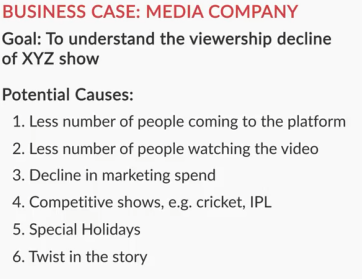

Let us now understand the data that we will use to derive our insights.

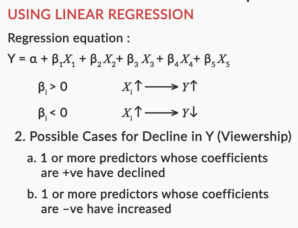

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
media_dataset_filepath = '/content/drive/MyDrive/UG-ML-AI/2.Machine_Learning-1/2.1_Linear_Regression/2. mediacompany.csv'
media_dataset_metadata_filepath = '/content/drive/MyDrive/UG-ML-AI/2.Machine_Learning-1/2.1_Linear_Regression/3. DataDictionary_mediacompany.csv'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import date
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [ ]:
# Reading the files
df_media_metadata = pd.read_csv(media_dataset_metadata_filepath)
df_media_metadata

,Variable,Explaination
0,Views_show,Number of times the show was viewed
1,Visitors,"Number of visitors who browsed the platform, b..."
2,Views_platform,Number of times a video was viewed on the plat...
3,Ad_impression,Proxy for marketing budget. Represents number ...
4,Cricket_match_india,If a cricket match was being played. 1 indicat...
5,Character_A,Describes presence of Character A. 1 indicates...


In [ ]:
df_media = pd.read_csv(media_dataset_filepath)
df_media.head()

,Date,Views_show,Visitors,Views_platform,Ad_impression,Cricket_match_india,Character_A,Unnamed: 7
0,3/1/2017,183738,1260228,1706478,1060860448,0,0,NaN
1,3/2/2017,193763,1270561,1690727,1031846645,0,0,NaN
2,3/3/2017,210479,1248183,1726157,1010867575,0,0,NaN
3,3/4/2017,240061,1492913,1855353,1079194579,1,0,NaN
4,3/5/2017,446314,1594712,2041418,1357736987,0,0,NaN


In [ ]:
df_media = df_media.drop('Unnamed: 7',axis=1)
df_media.head()

,Date,Views_show,Visitors,Views_platform,Ad_impression,Cricket_match_india,Character_A
0,3/1/2017,183738,1260228,1706478,1060860448,0,0
1,3/2/2017,193763,1270561,1690727,1031846645,0,0
2,3/3/2017,210479,1248183,1726157,1010867575,0,0
3,3/4/2017,240061,1492913,1855353,1079194579,1,0
4,3/5/2017,446314,1594712,2041418,1357736987,0,0


1 indicates that character A was present in the episode, 0 indicates she/he wasn't

# 2. Exploratory Data Analysis

Let’s try and see what we can learn from the data before going deeper into it.



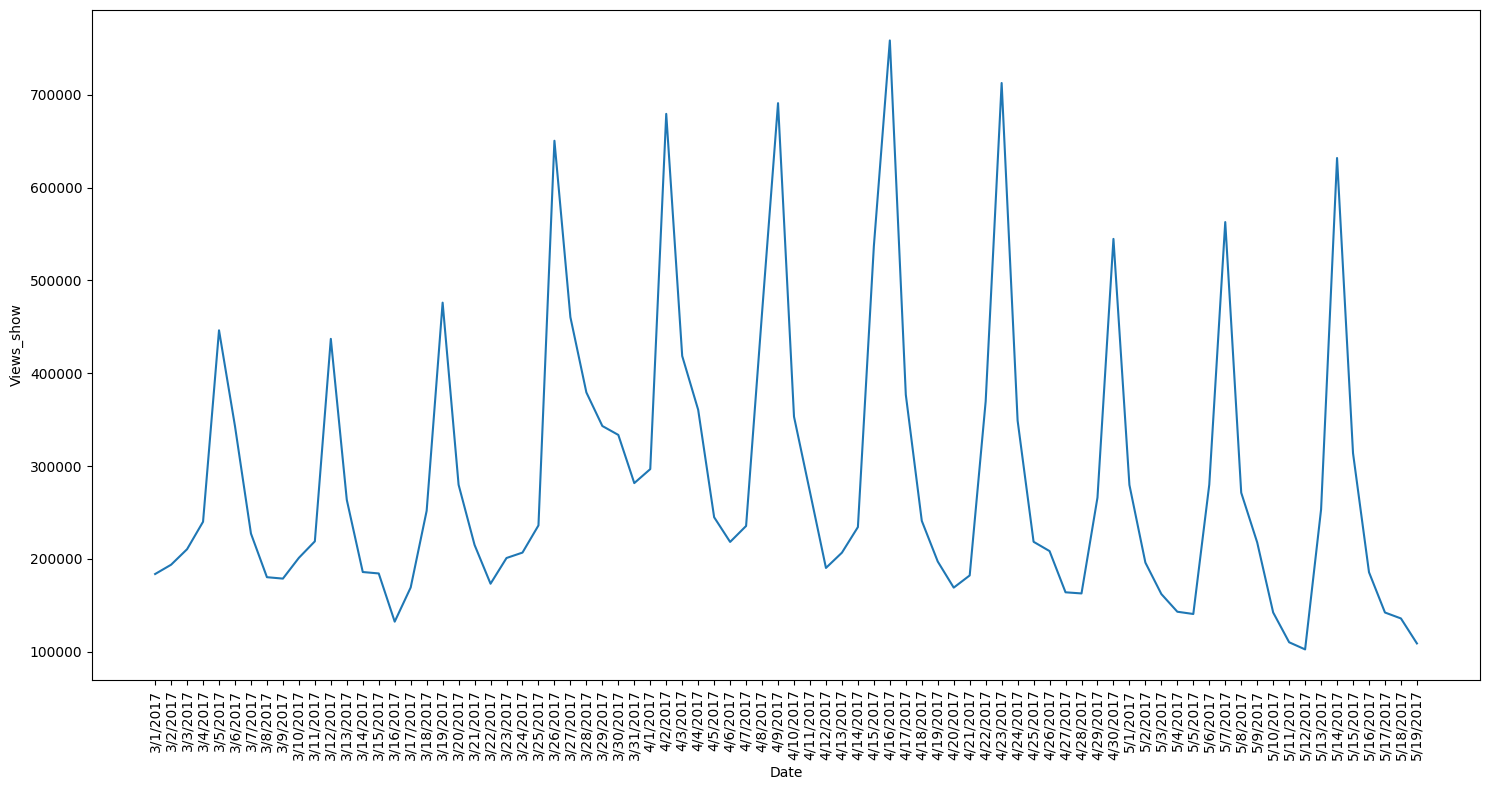

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(x='Date',y='Views_show',data=df_media)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Observations**

1. started at 20K base, then gradually bases and the spikes shot up for first 5 weeks.
2. After 1st 5 weeks , the bases and the spikes both started to decline.
3. It follows a weekly pattern

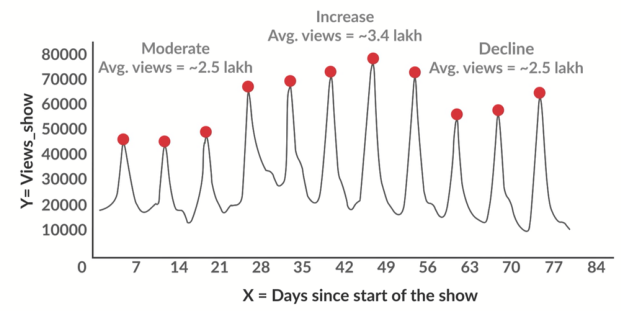

Let's plot the viewership of the show and the add impressions together

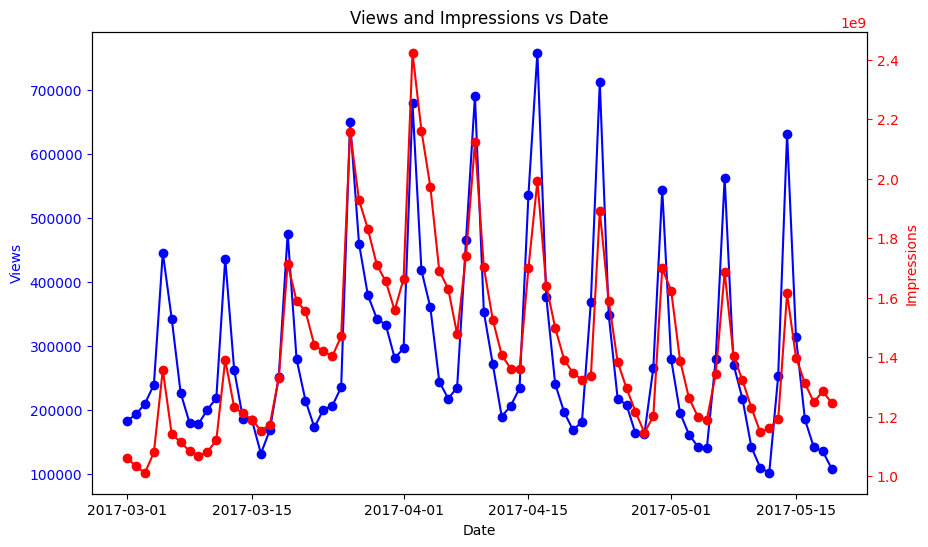

In [ ]:
# Convert 'Date' column to datetime type
df_media['Date'] = pd.to_datetime(df_media['Date'])

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting for Views on the left y-axis
ax1.plot(df_media['Date'], df_media['Views_show'], marker='o', color='b', label='Views')
ax1.set_xlabel('Date')
ax1.set_ylabel('Views', color='b')
ax1.tick_params('y', colors='b')

# Create a secondary y-axis for Impressions
ax2 = ax1.twinx()
ax2.plot(df_media['Date'], df_media['Ad_impression'], marker='o', color='r', label='Impressions')
ax2.set_ylabel('Impressions', color='r')
ax2.tick_params('y', colors='r')

# Adding labels and title
plt.title('Views and Impressions vs Date')

# Display the plot
plt.show()

**Observations**

1. Even the impressions follow weekly pattern.


You now have a good understanding of the viewership data. The next step is model building.



In [ ]:
# converting to date object
df_media['Date'] = pd.to_datetime(df_media['Date'])

In [ ]:
# Deriving "days since the show started"
d0 = date(2017, 2, 28)
d1 = df_media.Date
delta = pd.to_datetime(d1).dt.date - d0
df_media['day']= delta
df_media.head(2)

,Date,Views_show,Visitors,Views_platform,Ad_impression,Cricket_match_india,Character_A,day
0,2017-03-01,183738,1260228,1706478,1060860448,0,0,1 days
1,2017-03-02,193763,1270561,1690727,1031846645,0,0,2 days


In [ ]:
# Cleaning days
df_media['day'] = df_media['day'].astype(str)
df_media['day'] = df_media['day'].map(lambda x: x[0:2])
df_media['day'] = df_media['day'].astype(int)
df_media.head(2)

,Date,Views_show,Visitors,Views_platform,Ad_impression,Cricket_match_india,Character_A,day
0,2017-03-01,183738,1260228,1706478,1060860448,0,0,1
1,2017-03-02,193763,1270561,1690727,1031846645,0,0,2


In [ ]:
# Derived Metrics
# Weekdays are taken such that 1 corresponds to Sunday and 7 to Saturday
# Generate the weekday variable
df_media['weekday'] = (df_media['day']+3)%7
df_media.weekday.replace(0,7, inplace=True)
df_media['weekday'] = df_media['weekday'].astype(int)
df_media.head(2)

,Date,Views_show,Visitors,Views_platform,Ad_impression,Cricket_match_india,Character_A,day,weekday
0,2017-03-01,183738,1260228,1706478,1060860448,0,0,1,4
1,2017-03-02,193763,1270561,1690727,1031846645,0,0,2,5


# 3. Model Building - I

To arrive at a data-driven solution, you would use a linear regression model with an aim to understand what the predictors/driver KPIs for viewership are. Then, based on the model, you will be able to determine the root cause of the viewership decline.



Let us now dive into model building. Let's do the model building process through the **forward selection method**, which you learnt about in variable selection.

#### Building First model with only 2 Predictors

1. weekday , visitors (predictors)
2. views_show  (target)


In [ ]:
# Choosing X and y variables
X = df_media[['weekday','Visitors']]
y = df_media['Views_show']

# create a LR object using sklearn
lm = LinearRegression()

# fit the model on X
lm.fit(X,y)

LinearRegression()

In [ ]:
# building the model with statsmodels.api

# add constant
X = sm.add_constant(X)

# fit the model with OLS model
lm_1 = sm.OLS(y,X).fit()

# model summary
lm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Views_show   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     36.26
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           8.01e-12
Time:                        16:29:25   Log-Likelihood:                -1042.5
No. Observations:                  80   AIC:                             2091.
Df Residuals:                      77   BIC:                             2098.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.862e+04   1.07e+05     -0.360      0.720   -2.52e+05    1.75e+05
weekday    -3.591e+04   6591.205     -5.448      0.000    -4.9e+04   -2.28e+04
Visitors       0.2787      0.057      4.911      0.000       0.166       0.392
==============================================================================
Omnibus:                        2.684   Durbin-Watson:                   0.650
Prob(Omnibus):                  0.261   Jarque-Bera (JB):                2.653
Skew:                           0.423   Prob(JB):                        0.265
Kurtosis:                       2.718   Cond. No.                     1.46e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.46e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Observations**

1. Both the coefficients of weekday and visitors seems to be significant
2. Both these variables can explain variability of Views_show upto 48.5%
3. weekday coefficient is -ve , that indicates that there is a decline trend over the weekday, so it could be one of the factors leading to views decline.

#### 2. Building the model-2 with Weekend , Visitors as predictors

1. Predictors --> Weekend , Visitors
2. Target --> Views_show

Let's understand how the model performs when we consider weekend instead of weekday

Create a weekend variable

In [ ]:
# create Weekend variable, with value 1 at weekends(sat,sun) and 0 at weekdays
def cond(i):
    if i % 7 == 5: return 1
    elif i % 7 == 4: return 1
    else :return 0
    return i

df_media['weekend']=[cond(i) for i in df_media['day']]
df_media.head(2)

,Date,Views_show,Visitors,Views_platform,Ad_impression,Cricket_match_india,Character_A,day,weekday,weekend
0,2017-03-01,183738,1260228,1706478,1060860448,0,0,1,4,0
1,2017-03-02,193763,1270561,1690727,1031846645,0,0,2,5,0


In [ ]:
# choose X and y
X = df_media[['weekend','Visitors']]
y = df_media['Views_show']

# add constant
X = sm.add_constant(X)

# fit the model
lm_2 = sm.OLS(y,X).fit()

# model summary
lm_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Views_show   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     38.55
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           2.51e-12
Time:                        16:29:26   Log-Likelihood:                -1041.3
No. Observations:                  80   AIC:                             2089.
Df Residuals:                      77   BIC:                             2096.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.833e+04   1.01e+05     -0.875      0.384   -2.89e+05    1.13e+05
weekend     1.807e+05   3.15e+04      5.740      0.000    1.18e+05    2.43e+05
Visitors       0.1934      0.061      3.160      0.002       0.071       0.315
==============================================================================
Omnibus:                        1.302   Durbin-Watson:                   1.254
Prob(Omnibus):                  0.521   Jarque-Bera (JB):                1.367
Skew:                           0.270   Prob(JB):                        0.505
Kurtosis:                       2.656   Cond. No.                     1.41e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**observations**

1. weekend shows the positive correlation with views_show and hence the coeff is positive
2. adding weekend parameters increased the R^2 value to 50%
3. Both the coefficients seems to have significant p-value

#### 3. Building model-3 with variables (weekend,visitors,character A)

1. predictors --> weekend , visitors , character-A
2. target --> views_show

In [ ]:
# choose X and y
X = df_media[['weekend','Visitors','Character_A']]
y = df_media['Views_show']

# add constant
X = sm.add_constant(X)

# fit the model with statsmodels
lm_3 = sm.OLS(y,X).fit()

# model summary
lm_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Views_show   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     35.84
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           1.53e-14
Time:                        16:29:26   Log-Likelihood:                -1033.8
No. Observations:                  80   AIC:                             2076.
Df Residuals:                      76   BIC:                             2085.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.722e+04   9.31e+04     -0.507      0.613   -2.33e+05    1.38e+05
weekend      1.812e+05   2.89e+04      6.281      0.000    1.24e+05    2.39e+05
Visitors        0.1480      0.057      2.586      0.012       0.034       0.262
Character_A  9.542e+04   2.41e+04      3.963      0.000    4.75e+04    1.43e+05
==============================================================================
Omnibus:                        0.908   Durbin-Watson:                   1.600
Prob(Omnibus):                  0.635   Jarque-Bera (JB):                0.876
Skew:                          -0.009   Prob(JB):                        0.645
Kurtosis:                       2.488   Cond. No.                     1.42e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Observations**

1. Adding character_A seems to have great impact on views_show , hence the R^2 increased by nearly 9% from 50% --> 58.6% , whenever the character_A appears the views tend to increase greatly.
2. coefficients are highly positive
3. Even the adjusted-R^2 increased greatly, indicating the importance of the variable

first began the model with variables that seem the most important at the first instance. The model was updated with the change in variables, and the addition of new variables, that help explain the outcome better.



The first question you tried to answer was whether the decline in Visitors to the platform the main reason for the decline in the show viewership. You started with a weekday variable, and then replaced it with weekend variable to help explain the spikes in the graph better. Then you added the Character A variable, which shows the impact of the character's presence in the show Viewership.

#### 4. Build the model with 4 variables - weekend , visitors , character_A , views_show_lag_1day

1. predictors --> Lag_Views , weekend, visitors , character_A
2. target --> views_show

Intuitively it appears that the number of views today must be related to the views yesterday, e.g. if you had viewers watching the show yesterday, a large proportion of them are also expected to watch the show today.

Let's create the lag variable

In [ ]:
# creating a lag variable
df_media['Lag_Views'] = np.roll(df_media['Views_show'],1)
df_media.head()

,Date,Views_show,Visitors,Views_platform,Ad_impression,Cricket_match_india,Character_A,day,weekday,weekend,Lag_Views
0,2017-03-01,183738,1260228,1706478,1060860448,0,0,1,4,0,108961
1,2017-03-02,193763,1270561,1690727,1031846645,0,0,2,5,0,183738
2,2017-03-03,210479,1248183,1726157,1010867575,0,0,3,6,0,193763
3,2017-03-04,240061,1492913,1855353,1079194579,1,0,4,7,1,210479
4,2017-03-05,446314,1594712,2041418,1357736987,0,0,5,1,1,240061


In [ ]:
df_media.Lag_Views.replace(108961,0, inplace=True)
df_media.head()

,Date,Views_show,Visitors,Views_platform,Ad_impression,Cricket_match_india,Character_A,day,weekday,weekend,Lag_Views
0,2017-03-01,183738,1260228,1706478,1060860448,0,0,1,4,0,0
1,2017-03-02,193763,1270561,1690727,1031846645,0,0,2,5,0,183738
2,2017-03-03,210479,1248183,1726157,1010867575,0,0,3,6,0,193763
3,2017-03-04,240061,1492913,1855353,1079194579,1,0,4,7,1,210479
4,2017-03-05,446314,1594712,2041418,1357736987,0,0,5,1,1,240061


In [ ]:
# Choose X and y
X = df_media[['Lag_Views','Character_A','weekend','Visitors']]
y = df_media['Views_show']

# add constant
X = sm.add_constant(X)

# fit the model using statsapi
lm_4 = sm.OLS(y,X).fit()

# model summary
lm_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Views_show   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     53.46
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           3.16e-21
Time:                        16:29:26   Log-Likelihood:                -1015.1
No. Observations:                  80   AIC:                             2040.
Df Residuals:                      75   BIC:                             2052.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -2.98e+04   7.43e+04     -0.401      0.689   -1.78e+05    1.18e+05
Lag_Views       0.4317      0.065      6.679      0.000       0.303       0.560
Character_A  5.527e+04   2.01e+04      2.748      0.008    1.52e+04    9.53e+04
weekend      2.273e+05    2.4e+04      9.467      0.000    1.79e+05    2.75e+05
Visitors        0.0659      0.047      1.394      0.167      -0.028       0.160
==============================================================================
Omnibus:                        1.425   Durbin-Watson:                   2.626
Prob(Omnibus):                  0.491   Jarque-Bera (JB):                0.821
Skew:                          -0.130   Prob(JB):                        0.663
Kurtosis:                       3.423   Cond. No.                     1.44e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Observations**

1. Adding Lag_Views shows high correlation with the views , that is indicating our intuition of yesterday views impacts the current day views as true.
2. R^2 and Adjusted R^2 increased significantly
3. Lag_Views has significant positive coefficient
4. But p-value of coefficient of Visitors is 16% > 5% significance level. That means visitors is not much siginificant much for the model anymore once we introduced the lag.

**Quick check of our observations**

 1) Is Lag_views a significant predictor of Show_views, when modelled along "Weekend", "Visitors" and "Character_A"?


CHOICES:

● **Yes**

● No


ANSWERS:

For Lag_views, p < 0.05. Thus, Lag_views is a significant predictor of the viewership of the show.


2) What is the correlation between Lag_views and Views_show?


CHOICES:

● 0.74

● 0.89

● **0.42**

● 0.2

To know the correlation let's plot the heatmap

<ipython-input-21-e37fa2e2b170>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_media.corr(),annot=True)


<Axes: >

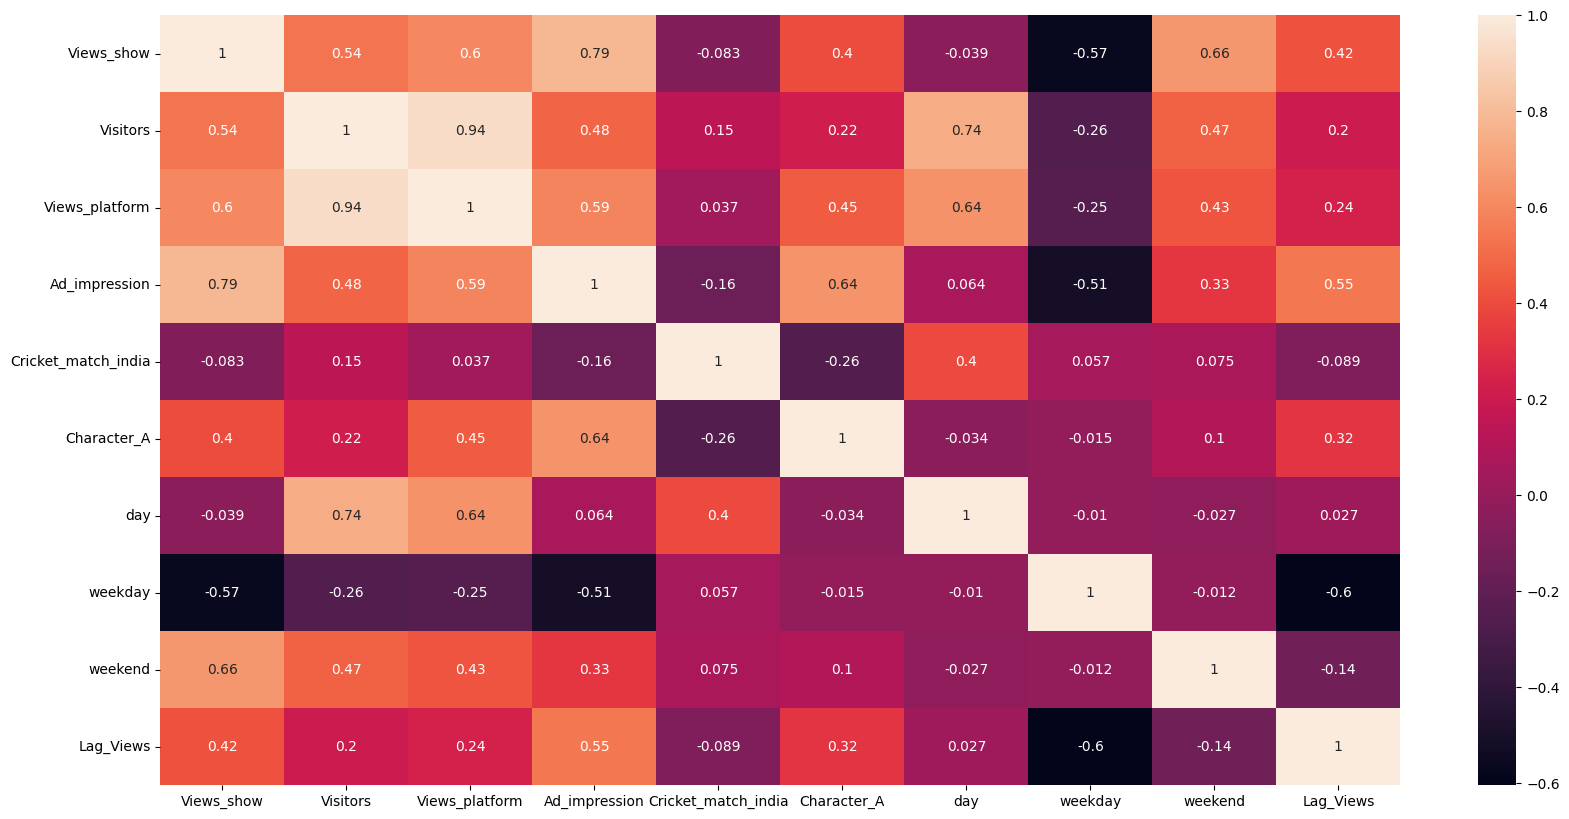

In [ ]:
# heatmap
plt.figure(figsize=(20,10))
sns.heatmap(df_media.corr(),annot=True)

# Model Building - II

Let us now look at the subsequent steps in model building

Instead of using lag_view , let's introduce the viewership to the platform as a metric here.

Because lag metrics sometimes can be misinterpreted by business people as , if we influence more of the people who visited yesterday , we can increase the viewership . Our emphasis should be more on bringing the new customers while retaining the old customers as well.

#### Model-6 using Weekend , Views Platform , Character A

1. predictors --> Weekend , Views platform , character A
2. target --> Views_show

In [55]:
# Choose X and y
X_6 = df_media[['Character_A','weekend','Views_platform']]
y = df_media['Views_show']

# add constant
X = sm.add_constant(X)

# fit the model using statsapi
lm_6 = sm.OLS(y,X).fit()

# model summary
lm_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Views_show   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     151.7
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           1.95e-27
Time:                        17:22:38   Log-Likelihood:                -1005.2
No. Observations:                  80   AIC:                             2016.
Df Residuals:                      77   BIC:                             2023.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.302e+05   4.01e+04     -5.744      0.000    -3.1e+05    -1.5e+05
weekend        1.551e+05   1.87e+04      8.282      0.000    1.18e+05    1.92e+05
Ad_impression     0.0003   2.82e-05     11.736      0.000       0.000       0.000
==============================================================================
Omnibus:                        4.941   Durbin-Watson:                   1.282
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                4.423
Skew:                           0.399   Prob(JB):                        0.110
Kurtosis:                       3.831   Cond. No.                     7.52e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.52e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Observations**

1. All 3 of them are positively correlated but the R^2 has gone down to 60% from 74% before.

#### Model-7 : Replace views_platform with Visitors again

Visitors is something that is directly impacted by the marketing actions and not the views.

Because views cannot be enforced because people watch only if the users like the content

1. Predictors --> Visitors , weekend , character A
2. target --> views_show

In [ ]:
# Choose X and y
X = df_media[['Character_A','weekend','Visitors']]
y = df_media['Views_show']

# add constant
X = sm.add_constant(X)

# fit the model using statsapi
lm_7 = sm.OLS(y,X).fit()

# model summary
lm_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Views_show   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     35.84
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           1.53e-14
Time:                        16:29:28   Log-Likelihood:                -1033.8
No. Observations:                  80   AIC:                             2076.
Df Residuals:                      76   BIC:                             2085.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.722e+04   9.31e+04     -0.507      0.613   -2.33e+05    1.38e+05
Character_A  9.542e+04   2.41e+04      3.963      0.000    4.75e+04    1.43e+05
weekend      1.812e+05   2.89e+04      6.281      0.000    1.24e+05    2.39e+05
Visitors        0.1480      0.057      2.586      0.012       0.034       0.262
==============================================================================
Omnibus:                        0.908   Durbin-Watson:                   1.600
Prob(Omnibus):                  0.635   Jarque-Bera (JB):                0.876
Skew:                          -0.009   Prob(JB):                        0.645
Kurtosis:                       2.488   Cond. No.                     1.42e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Model-8 : Introducing Ad impressions

1. predictors --> visitors , weekend , character_A , Ad_impression
2. target --> views_show

In [58]:
# Choose X and y
X_8 = df_media[['Character_A','weekend','Visitors','Ad_impression']]
y = df_media['Views_show']

# add constant
X = sm.add_constant(X)

# fit the model using statsapi
lm_8 = sm.OLS(y,X).fit()

# model summary
lm_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Views_show   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     151.7
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           1.95e-27
Time:                        17:24:07   Log-Likelihood:                -1005.2
No. Observations:                  80   AIC:                             2016.
Df Residuals:                      77   BIC:                             2023.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.302e+05   4.01e+04     -5.744      0.000    -3.1e+05    -1.5e+05
weekend        1.551e+05   1.87e+04      8.282      0.000    1.18e+05    1.92e+05
Ad_impression     0.0003   2.82e-05     11.736      0.000       0.000       0.000
==============================================================================
Omnibus:                        4.941   Durbin-Watson:                   1.282
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                4.423
Skew:                           0.399   Prob(JB):                        0.110
Kurtosis:                       3.831   Cond. No.                     7.52e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.52e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Observations**

1. Adding Ad_impression  significantly improved R^2 which is indicating that R^2 is a good thing.
2. But the p-value of visitors coefficient increased significantly (73.5%). Visitors may not be much relevant may be because of the multicollinearity.
3. But if you observe the coefficient value of Character_A turned to negative , which was positive before. It seems to be the model is instable because positive sign indicates character_A is contributing to the views_show increase , but now negative sign is saying that character_A is causing the decline of the views_show.


so we can drop off either character_A/ visitors because of its sign , it is causing the instability in the model , visitors can dropped off because of its insignificant p-value



Let's compute the VIF to check for multicollinearity

In [ ]:
# VIF
# create a dataframe that will contain the names of all the feature variables and their respective

vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif


,Features,VIF
0,const,77.94
4,Ad_impression,2.21
1,Character_A,1.76
3,Visitors,1.52
2,weekend,1.33


Seems like none of the variables are multicollinear to each other. Which is a good sign

- On the introduction of more variables, the model starts gaining complexity.
- Some of the variables, which were significant earlier, now become insignificant.
- Variables which have better alternatives are replaced.
- You brought back variables which were previously removed to test if they fit the business requirement better.
- For example, you brought back Visitors as a predictor against Views to the platform, because Visitors could be impacted through marketing actions.

**QUIZ**

 1) What is the correlation between Views_platform and Visitors?


CHOICES:

● 43

● **94**

● 78

● 62


Correct. Since there is such a high correlation between Visitors and Views on the platform, replacing Views_platform with Visitors made no significant difference.

In the latest version of the model (Model 6), we have spotted two major problems -

1. The variable ‘Visitors’ has become insignificant with a large p-value and
2. The variable ‘character A’ has changed its sign.

**QUIZ**

1)

Why do you think Visitor's significance dropped upon the introduction of the Ad Impressions variable? Write your answer in the text box below.


There is a significant correlation between Ad Impressions and Visitors. Thus, after the introduction of Ad Impressions, Visitors became an insignificant variable.


2) Think of some possible reasons that the variable ‘character_A’ has changed its sign. Write your answer in the text box below.

CharacterA has a high correlation with Ad impressions. A change of sign upon the introduction of new variables suggests multicollinearity.



# Model Building - III

Let us continue the process of model building.

#### Model-9 : Drop the vistor as a KPI from model-8

1. Predictor --> weekend , character_A , Ad_impression
2. Target --> views_show

In [ ]:
# choose the data
X = df_media[['weekend','Character_A','Ad_impression']]
y = df_media['Views_show']

# add constant
X = sm.add_constant(X)

# fit the model
lm_9 = sm.OLS(y,X).fit()

# model summary
lm_9.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Views_show   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     103.0
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           1.05e-26
Time:                        16:29:28   Log-Likelihood:                -1004.2
No. Observations:                  80   AIC:                             2016.
Df Residuals:                      76   BIC:                             2026.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.661e+05   4.74e+04     -5.609      0.000   -3.61e+05   -1.72e+05
weekend         1.51e+05   1.88e+04      8.019      0.000    1.14e+05    1.89e+05
Character_A    -2.99e+04   2.14e+04     -1.394      0.167   -7.26e+04    1.28e+04
Ad_impression     0.0004   3.69e-05      9.875      0.000       0.000       0.000
==============================================================================
Omnibus:                        4.723   Durbin-Watson:                   1.169
Prob(Omnibus):                  0.094   Jarque-Bera (JB):                3.939
Skew:                           0.453   Prob(JB):                        0.139
Kurtosis:                       3.601   Cond. No.                     9.26e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.26e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# Lets also compute VIF to check for multicollinearity once again
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif

,Features,VIF
0,const,36.58
3,Ad_impression,1.95
2,Character_A,1.75
1,weekend,1.15


**Observations**

1. None of the VIF values are > 5 which is suggesting that they are not multicollinear
2. And after dropping the visitors field , the model still has R^2 of 80% and adjusted R^2 as 79%.
3. But the character_A has insignicant p-value of 16% and the coefficient also becomes -ve again.
4. Ad_impression coefficient shows to be very close to 0 but the significance of p-value is very good , how can that be possible , probably we need to scaling the Ad_impression by converting into millions

Lets convert the Ad_impressions into millions

In [ ]:
df_media['Ad_impression_million'] = df_media['Ad_impression']/1000000
df_media.head()

,Date,Views_show,Visitors,Views_platform,Ad_impression,Cricket_match_india,Character_A,day,weekday,weekend,Lag_Views,Ad_impression_million
0,2017-03-01,183738,1260228,1706478,1060860448,0,0,1,4,0,0,1060.860448
1,2017-03-02,193763,1270561,1690727,1031846645,0,0,2,5,0,183738,1031.846645
2,2017-03-03,210479,1248183,1726157,1010867575,0,0,3,6,0,193763,1010.867575
3,2017-03-04,240061,1492913,1855353,1079194579,1,0,4,7,1,210479,1079.194579
4,2017-03-05,446314,1594712,2041418,1357736987,0,0,5,1,1,240061,1357.736987


#### Model 10 : Introduce competition parameter along with Ad_impression million

In [ ]:
# choose the data
X = df_media[['weekend', 'Character_A','Ad_impression_million','Cricket_match_india']]
y = df_media['Views_show']

# add constant
X = sm.add_constant(X)

# fit the model
lr_10  = sm.OLS(y,X).fit()

# model summaryy
lr_10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Views_show   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     76.59
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           1.02e-25
Time:                        16:29:28   Log-Likelihood:                -1004.0
No. Observations:                  80   AIC:                             2018.
Df Residuals:                      75   BIC:                             2030.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -2.633e+05    4.8e+04     -5.484      0.000   -3.59e+05   -1.68e+05
weekend                1.521e+05    1.9e+04      7.987      0.000    1.14e+05     1.9e+05
Character_A           -3.196e+04   2.19e+04     -1.457      0.149   -7.57e+04    1.17e+04
Ad_impression_million   363.7938     37.113      9.802      0.000     289.861     437.727
Cricket_match_india   -1.396e+04   2.74e+04     -0.510      0.612   -6.85e+04    4.06e+04
==============================================================================
Omnibus:                        5.270   Durbin-Watson:                   1.161
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                4.560
Skew:                           0.468   Prob(JB):                        0.102
Kurtosis:                       3.701   Cond. No.                     9.32e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.32e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# Lets also compute VIF to check for multicollinearity once again
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif

,Features,VIF
0,const,37.08
3,Ad_impression_million,1.95
2,Character_A,1.81
1,weekend,1.16
4,Cricket_match_india,1.08


**Observations**

1. Now the coeff of Ad_impression became extremely positive because of the scaling into millions
2. All the VIF are low which is stating that there is no multicollinearity
3. Cricket_match seems to have negative correlation with views_show , that is why the coeff is extremely -ve. , however its p-value has insignificant value of 61%. Which might be because the viewers of the show are not cricket lovers and hence the p-value is not significant though it is negatively correlated with views_show
4. R^2 and adjusted R^2 are close to 80 and 79%

#### Model 11: Let's drop both the character_A and cricket_match and build the model

1. predictors --> Weekend , Ad impression
2. target --> views_show

In [ ]:
# choose X  and y
X = df_media[['weekend','Ad_impression']]
y = df_media['Views_show']

# add constant
X = sm.add_constant(X)

# fit the model
lm_11 = sm.OLS(y,X).fit()

# summary
lm_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Views_show   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     151.7
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           1.95e-27
Time:                        16:29:28   Log-Likelihood:                -1005.2
No. Observations:                  80   AIC:                             2016.
Df Residuals:                      77   BIC:                             2023.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.302e+05   4.01e+04     -5.744      0.000    -3.1e+05    -1.5e+05
weekend        1.551e+05   1.87e+04      8.282      0.000    1.18e+05    1.92e+05
Ad_impression     0.0003   2.82e-05     11.736      0.000       0.000       0.000
==============================================================================
Omnibus:                        4.941   Durbin-Watson:                   1.282
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                4.423
Skew:                           0.399   Prob(JB):                        0.110
Kurtosis:                       3.831   Cond. No.                     7.52e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.52e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# Lets also compute VIF to check for multicollinearity once again
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif

,Features,VIF
0,const,25.77
1,weekend,1.12
2,Ad_impression,1.12


**Observations**

1. Even with 2 variables R^2 and adjusted R^2 are close to 80%
2. Even the VIF seems to be significant
3. p-values of coeffs are significant

This seems to be an optimal model so far with less number of variables and significant vif and p-values

In the process of building the model, we checked for multiple variables and then arrived at the variables that best suited the model.

**QUIZ**

1) A cricket match between Australia and India is happening over the weekend. Should the producers be worried about losing show viewers to the match?


CHOICES:

● Yes

● **No**


Cricket Matches (featuring India) was found to be insignificant in explaining show viewership. Thus, the cricket match would not impact show viewership

2) we dropped the "Character A" variable because its coefficient came out negative and it was counter to the business understanding that the star presence of character A boosts viewership. What does this suggest? Would it make sense to rely on data and stop Character A's future appearances to give an additional boost to viewership?


If Character_A is only the reason for -ve viewership then we can take this business decision.



Now that we have a model, with a fairly high adjusted R-squared, it might seem that the task is done.

But we still might be missing out on an important variable.

 Thus, you need to assess the model. In the following lectures, let's do some important methods of assessing the model and confirming that the model we arrived at was the best we could have, given the data we have

# Assessing the model

We have arrived at a model which has a fairly high adjusted-R squared. This means that the model was able to explain the viewership pattern to a large extent.



Before we finalise the model, let us run some checks to assess if the model we built was right.

Our model has
1. R^2 = 79.8%
2. Adjusted R^2 = 79.2%

If both R^2 and adjusted R^2 are so close that means both th

Now we need to check that the error that we are getting from the model is **random or white noise**

In [35]:
lm_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Views_show   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     151.7
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           1.95e-27
Time:                        16:46:28   Log-Likelihood:                -1005.2
No. Observations:                  80   AIC:                             2016.
Df Residuals:                      77   BIC:                             2023.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.302e+05   4.01e+04     -5.744      0.000    -3.1e+05    -1.5e+05
weekend        1.551e+05   1.87e+04      8.282      0.000    1.18e+05    1.92e+05
Ad_impression     0.0003   2.82e-05     11.736      0.000       0.000       0.000
==============================================================================
Omnibus:                        4.941   Durbin-Watson:                   1.282
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                4.423
Skew:                           0.399   Prob(JB):                        0.110
Kurtosis:                       3.831   Cond. No.                     7.52e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.52e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We have got the coefficients of the variables let's use them to derive the predicted

In [36]:
predicted_values = lm_11.predict(X)
print(len(predicted_values))
predicted_values

80


0     120974.237348
1     111370.689064
2     104426.631724
3     282125.353160
4     374322.693315
          ...      
75    232584.653937
76    204088.416377
77    183005.426662
78    195117.850950
79    182264.184197
Length: 80, dtype: float64

In [37]:
print(len(df_media))

80


In [38]:
# derive a field for the predicted values
df_media['predicted_views_show'] = predicted_values


# derive error by subtracting actual-pred
df_media['error_terms'] = df_media['Views_show']-df_media['predicted_views_show']
df_media.head()

,Date,Views_show,Visitors,Views_platform,Ad_impression,Cricket_match_india,Character_A,day,weekday,weekend,Lag_Views,Ad_impression_million,predicted_views_show,error_terms
0,2017-03-01,183738,1260228,1706478,1060860448,0,0,1,4,0,0,1060.860448,120974.237348,62763.762652
1,2017-03-02,193763,1270561,1690727,1031846645,0,0,2,5,0,183738,1031.846645,111370.689064,82392.310936
2,2017-03-03,210479,1248183,1726157,1010867575,0,0,3,6,0,193763,1010.867575,104426.631724,106052.368276
3,2017-03-04,240061,1492913,1855353,1079194579,1,0,4,7,1,210479,1079.194579,282125.353160,-42064.353160
4,2017-03-05,446314,1594712,2041418,1357736987,0,0,5,1,1,240061,1357.736987,374322.693315,71991.306685


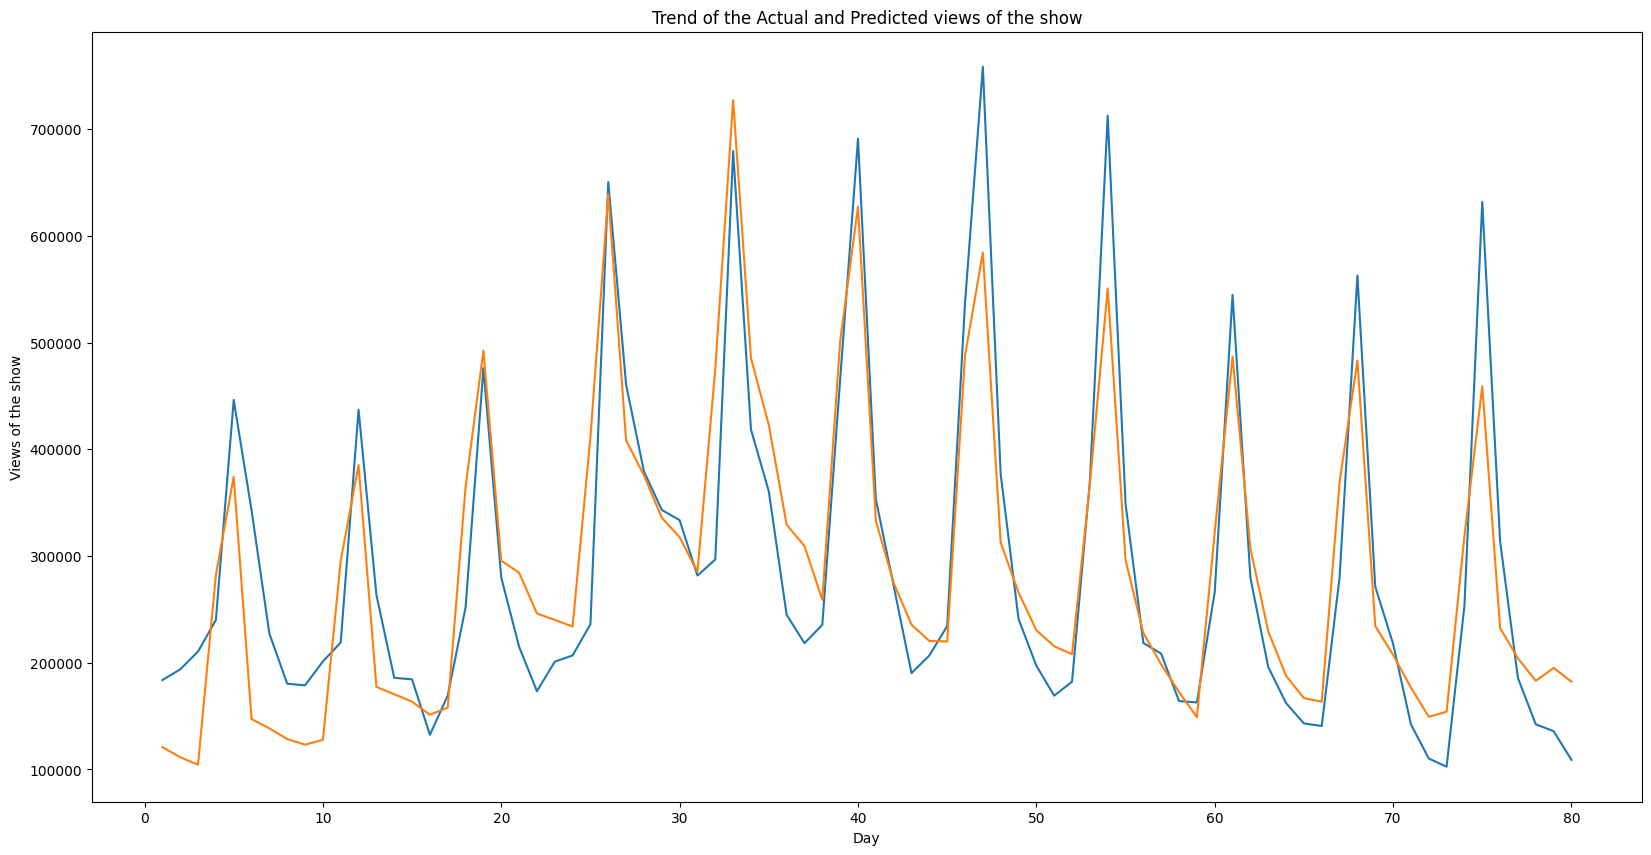

In [43]:
# plot the line of predicted values and actual views show
plt.figure(figsize=(20,10))
sns.lineplot(x='day',y='Views_show',data=df_media)

sns.lineplot(x='day',y='predicted_views_show',data=df_media,legend=True)
plt.xlabel('Day')
plt.ylabel('Views of the show')
plt.title('Trend of the Actual and Predicted views of the show')
plt.show()


From the above plot we can observe that predictions are pretty much good since both tend to follow the pattern closely.

Let's plot the error terms

<Axes: xlabel='day', ylabel='error_terms'>

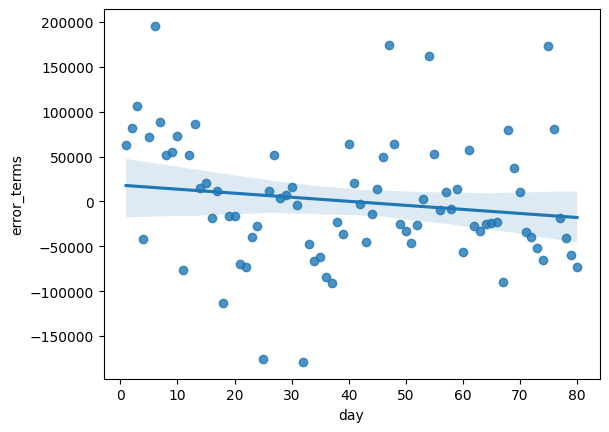

In [53]:
# scatterplot for error terms against the days
sns.regplot(data=df_media,x='day',y='error_terms')

Error is randomly distributed and therefore there is not much necessity to introduce a new variable into the model to improve the model.


We can stop building here

### Assessing the stability of Model

1. Data set is small
  - Not advisable to seperate training and test sets
2. Use bootstrapping
  - Choose 10-20% of sample randomly
  - Opt for multiple iterations with replacement
  - Train model on "in-sample" group
  - Test on "out-sample" group
3. Model is stable when R-squared is similar incase of both test and train sets.

We finally have a model that seems good enough to predict why the show viewership fell. You saw that the actual and predicted views overlapped, thus indicating that the model is able to explain the change in viewership very well.



Then, we saw that the errors (the differences between the actual views and the views predicted by the model) were randomly distributed. What this essentially confirms is that there are no variables that could have helped explain the model better.



A non-random error pattern, on the other hand, would mean that the errors are capturing some patterns, thus indicating that the model could have been better. A non-random error pattern indicates that there are certain systematic unexplained aspects in the outcomes that are being captured in the error. This pattern in the errors could probably have been explained by some explanatory variable which is missing from the model. So, the idea is that a model should explain everything that is possible, such that only the random errors are left.



So, in total, we built 8 models before you arrived at the final model. Let us check if the previous models would have passed the checks.

Let's take some other models that we have built previously how it could have predicted

like 5th model or 7th model

In [60]:
df_media['predicted_views_show_lm6']= lm_6.predict(X_6)

print(len(predicted_values))
predicted_values


# derive error by subtracting actual-pred
df_media['error_terms_lm6'] = df_media['Views_show']-df_media['predicted_views_show_lm6']

df_media.head()



80


,Date,Views_show,Visitors,Views_platform,Ad_impression,Cricket_match_india,Character_A,day,weekday,weekend,Lag_Views,Ad_impression_million,predicted_views_show,error_terms,predicted_views_show_lm6,error_terms_lm6
0,2017-03-01,183738,1260228,1706478,1060860448,0,0,1,4,0,0,1060.860448,120974.237348,62763.762652,564.843012,183173.156988
1,2017-03-02,193763,1270561,1690727,1031846645,0,0,2,5,0,183738,1031.846645,111370.689064,82392.310936,559.629442,193203.370558
2,2017-03-03,210479,1248183,1726157,1010867575,0,0,3,6,0,193763,1010.867575,104426.631724,106052.368276,571.356747,209907.643253
3,2017-03-04,240061,1492913,1855353,1079194579,1,0,4,7,1,210479,1079.194579,282125.353160,-42064.353160,155696.651943,84364.348057
4,2017-03-05,446314,1594712,2041418,1357736987,0,0,5,1,1,240061,1357.736987,374322.693315,71991.306685,155758.239326,290555.760674


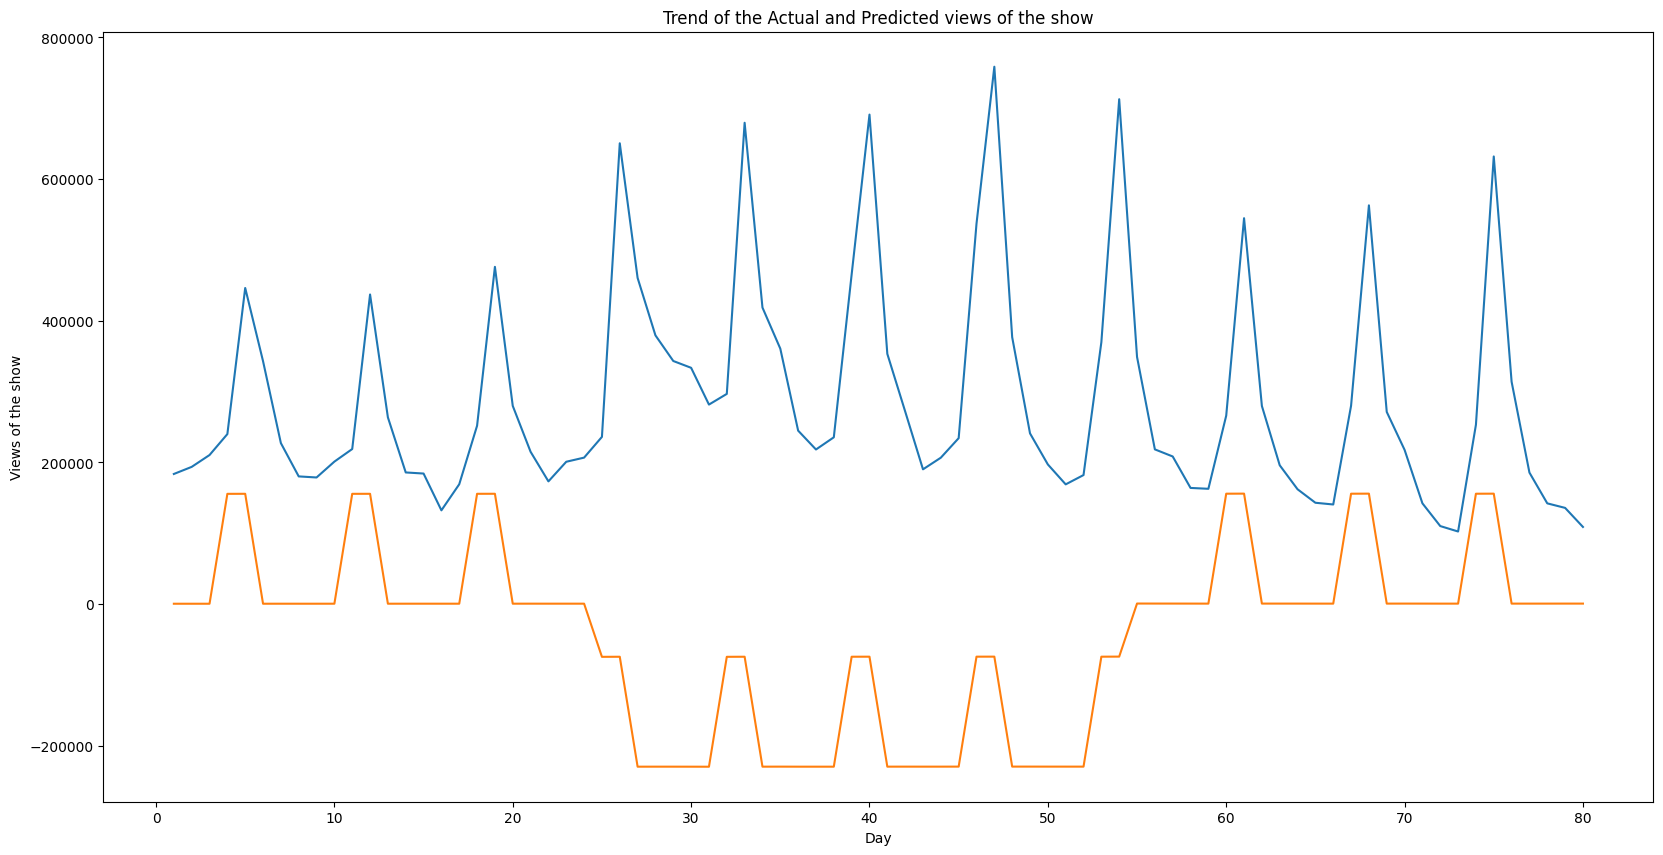

In [61]:
# plot the line of predicted values and actual views show
plt.figure(figsize=(20,10))
sns.lineplot(x='day',y='Views_show',data=df_media)

sns.lineplot(x='day',y='predicted_views_show_lm6',data=df_media,legend=True)
plt.xlabel('Day')
plt.ylabel('Views of the show')
plt.title('Trend of the Actual and Predicted views of the show')
plt.show()


<Axes: xlabel='day', ylabel='error_terms_lm6'>

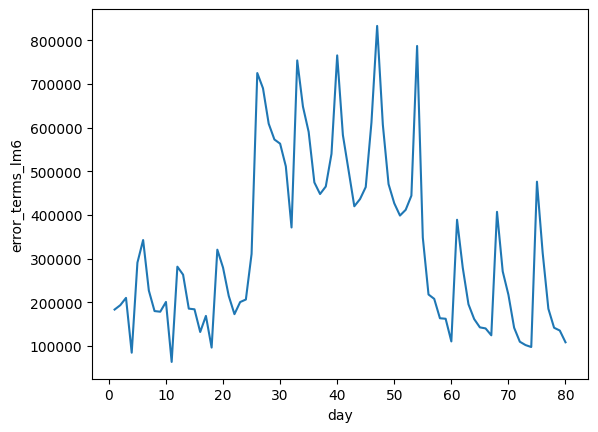

In [63]:
# scatterplot for error terms against the days
sns.lineplot(data=df_media,x='day',y='error_terms_lm6')

We can see that the other model performs very poorly

We saw that the plot results for model 5 were clearly not as good as model 11. The views predicted by model 5 were not able to capture the highs and lows that the actual show views had. **There was a seasonality pattern in the error plot. This pattern in the errors could probably have been explained by some explanatory variable which is missing from model 5.**



A good model tells a good story. It is not important that you base your story entirely on a single model. Drawing insights from the current model (model 9) and previous models,We identified **Ad Impressions and Character A** as the driver variables that could be used to increase the viewership of the show. Ad impressions are **directly proportional to the marketing budget**. Thus, by increasing the marketing budget, a better viewership could be achieved. Similarly, Character A’s absence and presence create a significant change in show viewership. Character A’s presence brings viewers to the show. Thus, these two variables can be acted upon to improve the show viewership.

# Interpreting the Results

It is not always possible to change the script of the story at a moment’s notice. Character A’s dates might also not be available. Thus, the marketing team can focus on the ad impressions instead.

Let us understand how the model could be used by the marketing team to drive ad impressions.

In [64]:
df_media.head()

,Date,Views_show,Visitors,Views_platform,Ad_impression,Cricket_match_india,Character_A,day,weekday,weekend,Lag_Views,Ad_impression_million,predicted_views_show,error_terms,predicted_views_show_lm6,error_terms_lm6
0,2017-03-01,183738,1260228,1706478,1060860448,0,0,1,4,0,0,1060.860448,120974.237348,62763.762652,564.843012,183173.156988
1,2017-03-02,193763,1270561,1690727,1031846645,0,0,2,5,0,183738,1031.846645,111370.689064,82392.310936,559.629442,193203.370558
2,2017-03-03,210479,1248183,1726157,1010867575,0,0,3,6,0,193763,1010.867575,104426.631724,106052.368276,571.356747,209907.643253
3,2017-03-04,240061,1492913,1855353,1079194579,1,0,4,7,1,210479,1079.194579,282125.353160,-42064.353160,155696.651943,84364.348057
4,2017-03-05,446314,1594712,2041418,1357736987,0,0,5,1,1,240061,1357.736987,374322.693315,71991.306685,155758.239326,290555.760674


In [71]:
# Computing the impression growth per day (next_day-present_day)/present_day --> growth
df_media['impression_growth_in_perc'] = round((df_media['Ad_impression_million']-np.roll(df_media['Ad_impression_million'],1))/df_media['Ad_impression_million'],2)*100

df_media.tail()

,Date,Views_show,Visitors,Views_platform,Ad_impression,Cricket_match_india,Character_A,day,weekday,weekend,Lag_Views,Ad_impression_million,predicted_views_show,error_terms,predicted_views_show_lm6,error_terms_lm6,impression_growth_in_perc
75,2017-05-15,313945,1808684,2226788,1398052759,1,0,76,2,0,631962,1398.052759,232584.653937,81360.346063,737.065254,313207.934746,-15.0
76,2017-05-16,185689,1814227,2199844,1311961223,1,0,77,3,0,313945,1311.961223,204088.416377,-18399.416377,728.146809,184960.853191,-7.0
77,2017-05-17,142260,1755803,2225752,1248266254,1,0,78,4,0,185689,1248.266254,183005.426662,-40745.426662,736.722339,141523.277661,-5.0
78,2017-05-18,135871,1749654,2302789,1284859759,1,0,79,5,0,142260,1284.859759,195117.850950,-59246.850950,762.221531,135108.778469,3.0
79,2017-05-19,108961,1746735,2279036,1246026846,1,0,80,6,0,135871,1246.026846,182264.184197,-73303.184197,754.359305,108206.640695,-3.0


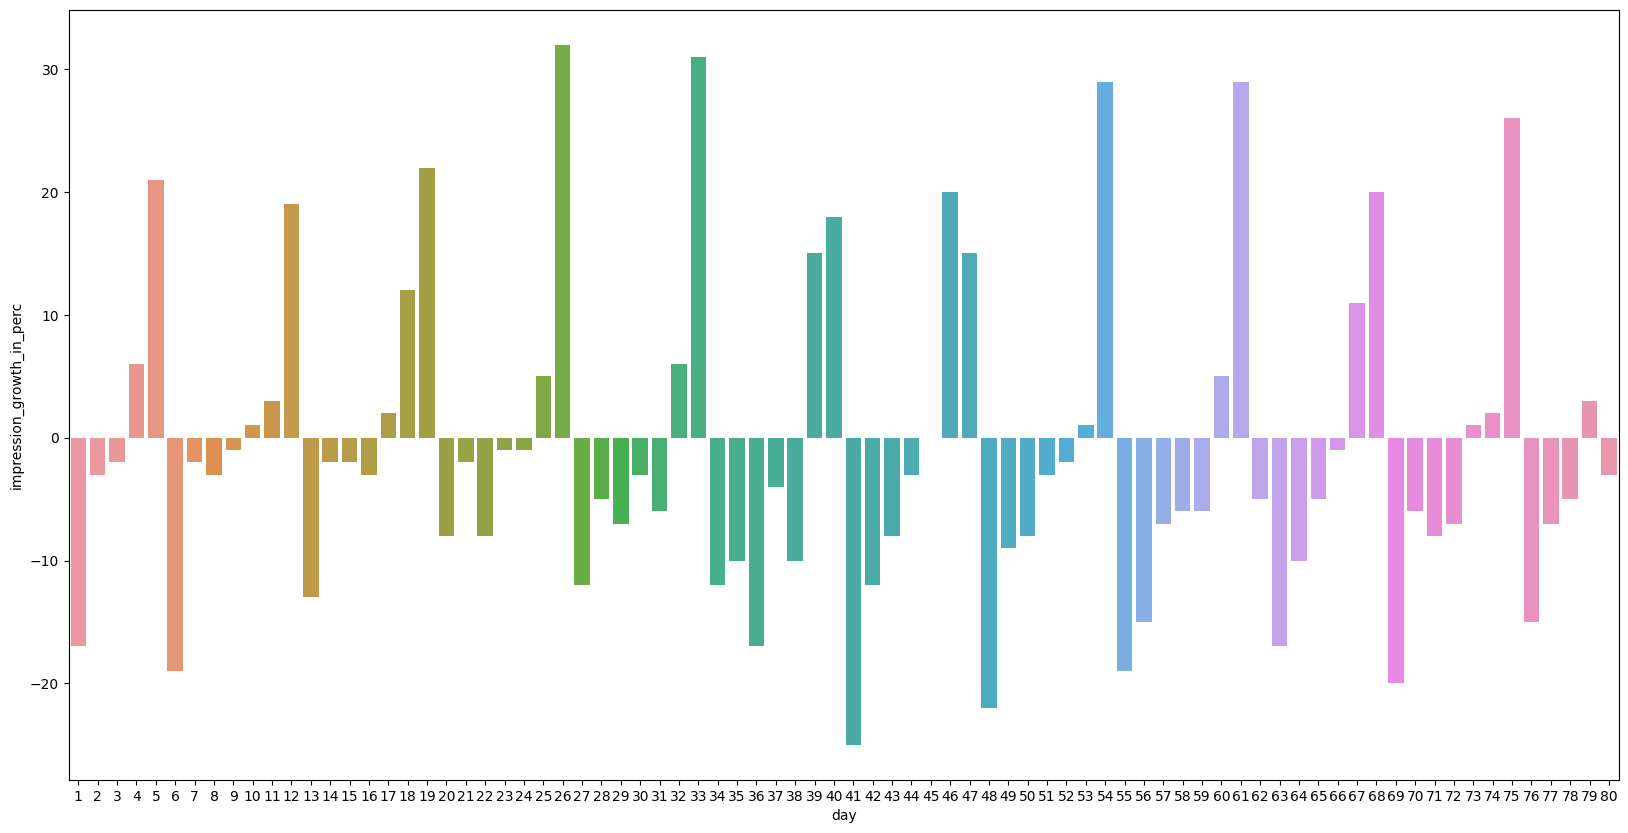

In [76]:
# plot impression growth
plt.figure(figsize=(20,10))
sns.barplot(x='day',y='impression_growth_in_perc',data=df_media)
plt.show()

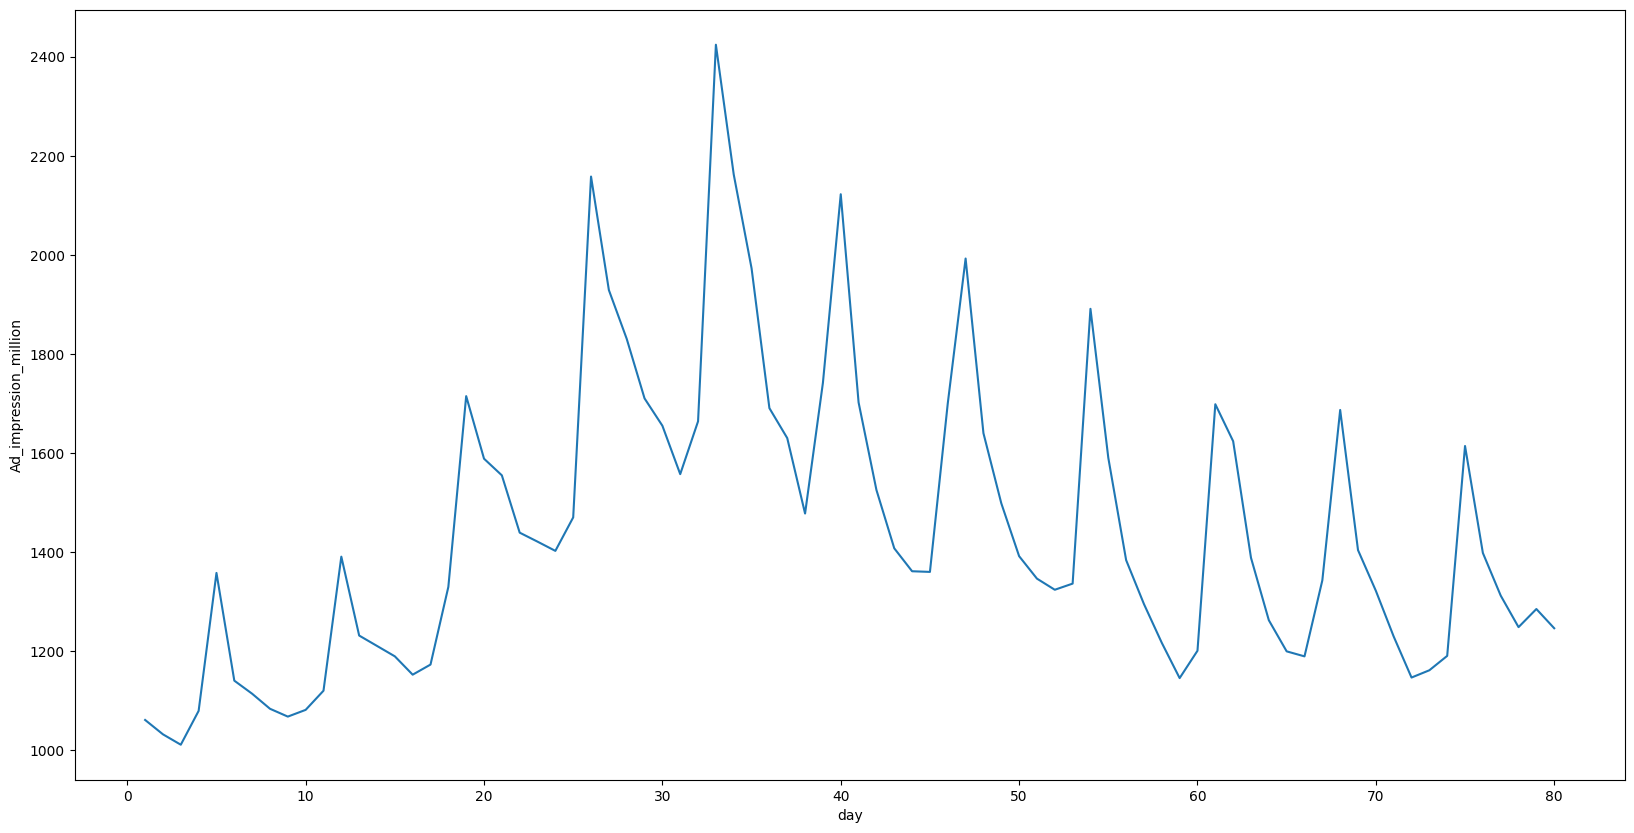

In [75]:
# plot impression growth
plt.figure(figsize=(20,10))
sns.lineplot(x='day',y='Ad_impression_million',data=df_media)
plt.show()

We can observe that the impression are declining gradually for the last few weeks.

We can suggest that to our marketing team to boost the impressions

In [77]:
# computing the max and min impressions to estimate the marketing costs to boost the impression
difference =df_media['Ad_impression_million'].max() - df_media['Ad_impression_million'].min()

print('Max-min difference of impressions in millions is : {}'.format(difference))

Max-min difference of impressions in millions is : 1413.3353730000001


The marketing team wanted to know the additional investment required to increase the ad impressions and thus, increase the viewership of the show.



Model equation was used to find out the increase in ad impressions required to take show viewership back to the peak levels attained in week 13. The ad impressions figure could then be used the marketing team to calculate the required increase in marketing budget.

# Summary

Let’s summarise what we have done:

1. It is important to understand if a linear regression modelling will be applicable to the problem you are trying to solve. E.g. linear regression can’t help you decide if a customer will opt out of a subscription, as this is a classification problem.
2. Linear regression guarantees interpolation but not extrapolation.
3. While linear regression can be used for both projection and prediction, there is a difference between the two. In prediction, the goal is to identify the most important variables that explain the outcome in a simpler way. In projection, the goal is to accurately forecast the outcome, no matter how complex the model gets.
5. The business goal is crucial and will decide what path the modelling process should take.
In the industry, variables that are actionable are valued over others. E.g. given two quite similar variables, “Views to the platform” and “Visitors to the platform”, the latter is more actionable, as it is easier to get viewers to the platform than forcing anybody to watch the shows.
6. You don’t end the modelling process until you are sure that no more significant variables could be added to explain the outcome. Thus, you check for randomness of errors, which could indicate if any KPI that could have helped explain the outcome was left out.